In [25]:
# Project Progress Report — UCS Satellite Database
# Goal: Predict satellite Purpose from orbital and mass features.

# Target:`Purpose`  
# Predictors: `OrbitClass`, `GEOLongitude`, `Perigee`, `Apogee`, `Eccentricity`, `Inclination`, `Period`, `LaunchMass`

#Authors: Jess Hammond, Gary Kuepper, Keshab Neupane

In [26]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay

In [27]:
url = "UCS-Satellite-Database-Officialname_5-1-2023.xlsx"
df = pd.read_excel(url, sheet_name="Sheet1")
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7560 entries, 0 to 7559
Data columns (total 67 columns):
 #   Column                              Non-Null Count  Dtype  
---  ------                              --------------  -----  
 0   Current Official Name of Satellite  7560 non-null   object 
 1   Country/Org of UN Registry          7559 non-null   object 
 2   Country of Operator/Owner           7560 non-null   object 
 3   Operator/Owner                      7560 non-null   object 
 4   Users                               7560 non-null   object 
 5   Purpose                             7560 non-null   object 
 6   Detailed Purpose                    1254 non-null   object 
 7   Class of Orbit                      7560 non-null   object 
 8   Type of Orbit                       6909 non-null   object 
 9   Longitude of GEO (degrees)          7557 non-null   float64
 10  Perigee (km)                        7553 non-null   float64
 11  Apogee (km)                         7553 no

In [28]:
# This cleans the table: we rename long column names to shorter ones, drop the junk "Unnamed:*" columns, merge all the Source* columns into one text field (SourcesAll), and convert LaunchDate to a real date so we can also make LaunchYear.

In [29]:
# Clean data
rename_map = {
    'Current Official Name of Satellite': 'SatelliteName',
    'Country/Org of UN Registry': 'UNRegistry',
    'Country of Operator/Owner': 'Country',
    'Operator/Owner': 'Operator',
    'Users': 'Users',
    'Purpose': 'Purpose',
    'Detailed Purpose': 'DetailedPurpose',
    'Class of Orbit': 'OrbitClass',
    'Type of Orbit': 'OrbitType',
    'Longitude of GEO (degrees)': 'GEOLongitude',
    'Perigee (km)': 'Perigee',
    'Apogee (km)': 'Apogee',
    'Eccentricity': 'Eccentricity',
    'Inclination (degrees)': 'Inclination',
    'Period (minutes)': 'Period',
    'Launch Mass (kg.)': 'LaunchMass',
    'Dry Mass (kg.)': 'DryMass',
    'Power (watts)': 'Power',
    'Date of Launch': 'LaunchDate',
    'Expected Lifetime (yrs.)': 'LifetimeYrs',
    'Contractor': 'Contractor',
    'Country of Contractor': 'ContractorCountry',
    'Launch Site': 'LaunchSite',
    'Launch Vehicle': 'LaunchVehicle',
    'COSPAR Number': 'COSPAR',
    'NORAD Number': 'NORAD',
    'Comments': 'Comments'
}
df = df.rename(columns={k:v for k,v in rename_map.items() if k in df.columns})

# drop all Unnamed: columns
unnamed_cols = [c for c in df.columns if c.startswith("Unnamed:")]
df = df.drop(columns=unnamed_cols)

# combine Source columns into one text field
source_cols = [c for c in df.columns if c.startswith("Source")]
if len(source_cols) > 0:
    df['SourcesAll'] = df[source_cols] \
        .astype(str) \
        .replace({'nan': np.nan}) \
        .apply(lambda row: "; ".join([v for v in row if pd.notna(v)]), axis=1)
    df = df.drop(columns=source_cols)

if 'LaunchDate' in df.columns:
    df['LaunchDate'] = pd.to_datetime(df['LaunchDate'], errors='coerce')
    df['LaunchYear'] = df['LaunchDate'].dt.year

In [30]:
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7560 entries, 0 to 7559
Data columns (total 29 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   SatelliteName      7560 non-null   object        
 1   UNRegistry         7559 non-null   object        
 2   Country            7560 non-null   object        
 3   Operator           7560 non-null   object        
 4   Users              7560 non-null   object        
 5   Purpose            7560 non-null   object        
 6   DetailedPurpose    1254 non-null   object        
 7   OrbitClass         7560 non-null   object        
 8   OrbitType          6909 non-null   object        
 9   GEOLongitude       7557 non-null   float64       
 10  Perigee            7553 non-null   float64       
 11  Apogee             7553 non-null   float64       
 12  Eccentricity       7549 non-null   float64       
 13  Inclination        7556 non-null   float64       
 14  Period  

In [31]:
# This part cleans the Purpose text (drops blanks, trims spaces, fixes casing), then groups many messy purpose labels into a few simple buckets: Communications, Navigation, Technology (incl. educational/platform), Science (Earth), Science (Space), 
# and Science (Earth+Space). We apply the mapper to create PurposeSuperAudit, print the new bucket counts, and list anything that still fell into Other so we can fix it.

In [32]:
target_col = 'Purpose'

num_cols = [c for c in ['GEOLongitude','Perigee','Apogee','Eccentricity','Inclination','Period','LaunchMass'] if c in df.columns]
cat_cols = [c for c in ['OrbitClass'] if c in df.columns]

# Drop rows missing Purpose
dfm = df.dropna(subset=[target_col]).copy()

# Remove leading/trailing spaces and double spaces
dfm[target_col] = (
    dfm[target_col]
      .astype(str)
      .str.strip()                
      .str.replace(r"\s+", " ", regex=True) 
)

# Standardize capitalization
dfm[target_col] = dfm[target_col].str.title()

# Old buckets
print(dfm[target_col].value_counts().head(50))

# Combine purposes and remove redundant labels (Eg. Space Science & Space Observation)
def map_purpose_science_style(p):
    s = str(p).lower().strip()
    s = " ".join(s.split())

    # Buckets
    if "surveillance" in s:
        return "Surveillance"
    if "communicat" in s:
        return "Communications"
    if "navigation" in s or "positioning" in s:
        return "Navigation"
    if "mission extension" in s or "technology" in s:
        return "Technology"
    if "educational" in s or "education" in s: 
        return "Technology"
    if "platform" in s: 
        return "Technology"

    # Science buckets
    space_flag = any(k in s for k in ["space science", "space observation"])
    earth_flag = any(k in s for k in ["earth observation", "earth science", "meteorolog", "earth/space observation"])

    if earth_flag and space_flag:
        return "Science (Earth+Space)"
    if earth_flag:
        return "Science (Earth)"
    if space_flag:
        return "Science (Space)"

    if "unknown" in s:
        return "Unknown"
    return "Other"

dfm["PurposeSuperAudit"] = dfm["Purpose"].apply(map_purpose_science_style)

# New buckets
print(dfm["PurposeSuperAudit"].value_counts())

dfm.loc[dfm["PurposeSuperAudit"]=="Other", ["Purpose"]].value_counts().head(20)

Purpose
Communications                                    5514
Earth Observation                                 1238
Technology Development                             372
Navigation/Global Positioning                      142
Space Science                                       99
Technology Demonstration                            64
Earth Science                                       28
Surveillance                                        20
Navigation/Regional Positioning                     13
Unknown                                             10
Earth Observation/Navigation                         9
Space Observation                                    9
Earth Observation/Technology Development             7
Meteorological                                       6
Communications/Maritime Tracking                     5
Earth/Space Observation                              4
Communications/Technology Development                4
Earth Observation/Communications                     2
Mi

Series([], Name: count, dtype: int64)

In [33]:
# We take the cleaned Purpose buckets, drop rows labeled “Unknown,” and split the data into train (80%) and test (20%). We fill missing numbers with the train median, turn OrbitClass into one-hot columns, and standardize the numeric features. 
# Then we train a Logistic Regression model, print the accuracy and the per-class scores, and show a confusion matrix to see which classes the model confuses.

In [34]:
target_col = "PurposeSuperAudit"

# Drop Unknown label
dfm_model = dfm[~dfm[target_col].isin(["Unknown"])].copy()

X = dfm_model[num_cols + cat_cols].copy()
y = dfm_model[target_col].copy()

X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state=42, test_size=0.2)

# Impute numerics with median
for c in num_cols:
    med = X_train[c].median()
    X_train[c] = X_train[c].fillna(med)
    X_test[c]  = X_test[c].fillna(med)

X_train[cat_cols] = X_train[cat_cols].astype(str)
X_test[cat_cols]  = X_test[cat_cols].astype(str)

# Trun orbitalclass into 0 or 1
ohe = OneHotEncoder(handle_unknown='ignore', sparse_output=False)
ohe.fit(X_train[cat_cols])
Z_train_cat = ohe.transform(X_train[cat_cols])
Z_test_cat  = ohe.transform(X_test[cat_cols])

# Scale numerics
scaler = StandardScaler().fit(X_train[num_cols])
Z_train_num = scaler.transform(X_train[num_cols])
Z_test_num  = scaler.transform(X_test[num_cols])

# Combine features
Z_train = np.hstack([Z_train_num, Z_train_cat])
Z_test  = np.hstack([Z_test_num, Z_test_cat])

lr = LogisticRegression(max_iter=600, solver='lbfgs', multi_class='multinomial', class_weight=None)
lr.fit(Z_train, y_train)
pred = lr.predict(Z_test)

print("Accuracy:", accuracy_score(y_test, pred))
print(classification_report(y_test, pred, zero_division=0))

Accuracy: 0.7675496688741722
                       precision    recall  f1-score   support

       Communications       0.78      0.96      0.86      1105
           Navigation       1.00      0.88      0.94        33
      Science (Earth)       0.57      0.25      0.35       255
Science (Earth+Space)       0.00      0.00      0.00         1
      Science (Space)       1.00      0.09      0.17        22
         Surveillance       0.00      0.00      0.00         4
           Technology       0.00      0.00      0.00        90

             accuracy                           0.77      1510
            macro avg       0.48      0.31      0.33      1510
         weighted avg       0.70      0.77      0.71      1510



C:\Users\gkuep\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\linear_model\_logistic.py:1272: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.8. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


['Communications', 'Navigation', 'Science (Earth)', 'Science (Earth+Space)', 'Science (Space)', 'Surveillance', 'Technology']
[[1064    0   40    0    0    1    0]
 [   4   29    0    0    0    0    0]
 [ 190    0   64    0    0    0    1]
 [   1    0    0    0    0    0    0]
 [  14    0    5    0    2    0    1]
 [   4    0    0    0    0    0    0]
 [  86    0    4    0    0    0    0]]


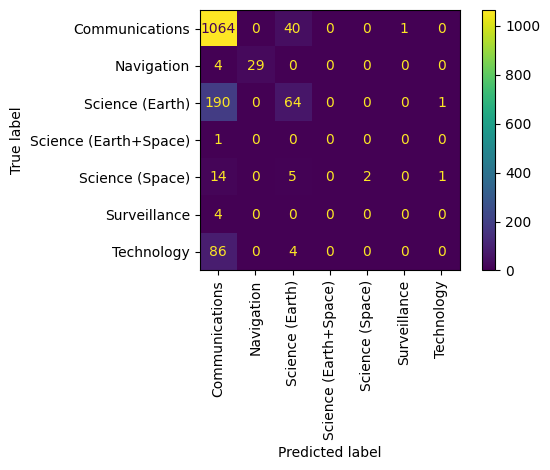

In [35]:
# confusion matrix
labels = sorted(y_test.unique())
cm = confusion_matrix(y_test, pred, labels=labels)
print(labels)
print(cm)

labels = sorted(y_test.unique())
ConfusionMatrixDisplay.from_predictions(y_test, pred, labels=labels, xticks_rotation=90)
plt.tight_layout(); plt.show()

In [36]:
# Bar chart shows how many satellites are in each Purpose bucket. Histograms show the spread of the numeric features (Perigee, Apogee, etc.).

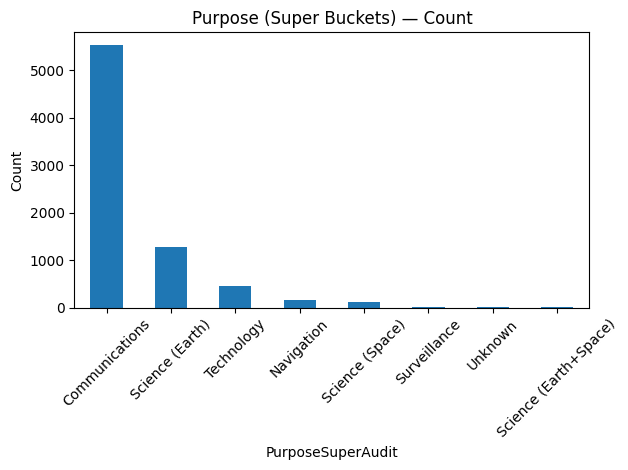

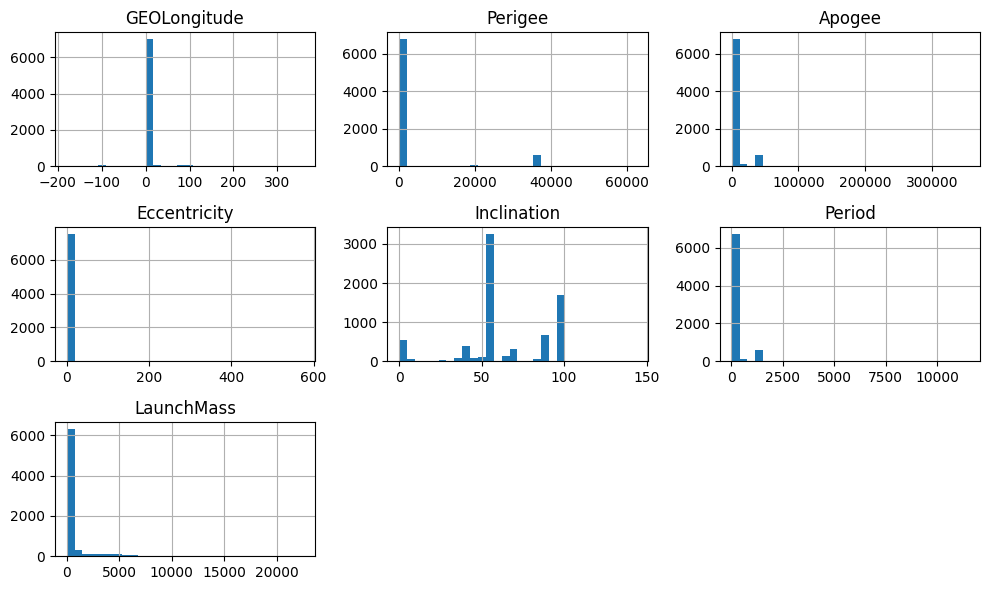

In [37]:
# Class counts bar chart
dfm["PurposeSuperAudit"].value_counts().plot(kind="bar", rot=45)
plt.title("Purpose (Super Buckets) — Count"); plt.ylabel("Count"); plt.tight_layout(); plt.show()

# Histograms for key numerics
dfm[num_cols].hist(bins=30, figsize=(10,6))
plt.tight_layout(); plt.show()